In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import unicodedata
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Preuzimanje potrebnih NLTK resursa
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('omw-1.4')

df = pd.read_csv('train.csv')

print(df.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kaca\AppData\Roaming\nltk_data...


   count  hate_speech_count  offensive_language_count  neither_count  class  \
0      3                  0                         0              3      2   
1      3                  0                         3              0      1   
2      3                  0                         3              0      1   
3      3                  0                         2              1      1   
4      6                  0                         6              0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  


[nltk_data]   Package omw-1.4 is already up-to-date!


#### Prikaz distribucije podataka

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Kreiraj novu kolonu 'label' za binarnu klasifikaciju
df['label'] = df['class'].apply(lambda x: 1 if x == 1 else 0)
df = df[['tweet', 'label']]
def plot_distribution(data, column):
# Prikaži distribuciju klasa
    class_counts = data[column].value_counts()
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Distribucija klasa')
    plt.xlabel('Klasa (0 = Nije govor mržnje, 1 = Govor mržnje)')
    plt.ylabel('Broj primera')
    plt.show()

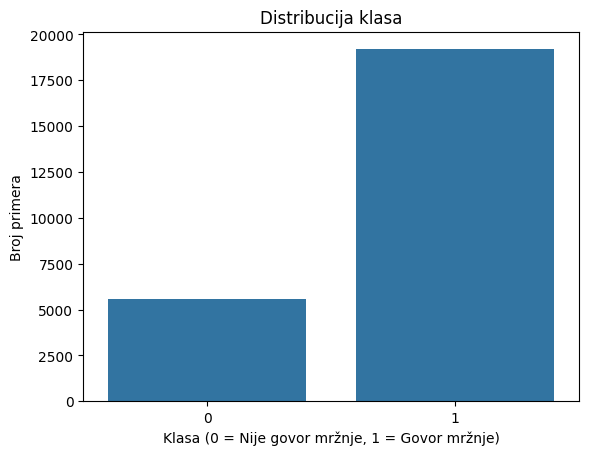

In [3]:
plot_distribution(df, 'label')

#### Preprocesiranje teksta

In [4]:
def preprocess_text(df, text_column):
    """
    Funkcija za predobradu teksta.
    
    Argumenti:
    - df: Pandas DataFrame koji sadrži kolonu sa tekstom.
    - text_column: Ime kolone koja sadrži tekstualne podatke.
    
    Vraća:
    - df: Pandas DataFrame sa novom kolonom 'clean_text' koja sadrži predobrađen tekst.
    """
    # Kopiramo originalni DataFrame da ne bismo menjali originalne podatke
    df = df.copy()
    
    # Uklanjanje URL-ova i email adresa
    df['clean_tweet'] = df[text_column].apply(lambda x: re.sub(r'http\S+|www.\S+|mailto:\S+', '', x))
    
    # Uklanjanje HTML tagova
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
    
    # Uklanjanje emotikona i specijalnih karaktera
    def remove_emojis(text):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emotikoni
                                   u"\U0001F300-\U0001F5FF"  # simobli i ikone
                                   u"\U0001F680-\U0001F6FF"  # transport i simobli
                                   u"\U0001F1E0-\U0001F1FF"  # zastave
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    df['clean_tweet'] = df['clean_tweet'].apply(remove_emojis)
    
    # Uklanjanje specijalnih karaktera i interpunkcije
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r'[^A-Za-zšđčćžŠĐČĆŽ ]+', ' ', x))
    
    # Pretvaranje u mala slova
    df['clean_tweet'] = df['clean_tweet'].str.lower()
    
    # Uklanjanje dijakritika
    def remove_diacritics(text):
        text = unicodedata.normalize('NFKD', text)
        text = ''.join([c for c in text if not unicodedata.combining(c)])
        return text

    df['clean_tweet'] = df['clean_tweet'].apply(remove_diacritics)
    
    # Uklanjanje višestrukih razmaka
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub('\s+', ' ', x).strip())
    
    # Tokenizacija
    df['tokens'] = df['clean_tweet'].apply(nltk.word_tokenize)
    
    # Uklanjanje stop-reči
    stop_words = set(stopwords.words('english'))  # Ako imaš stop-reči za srpski, zameni ovde
    df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
    
    # Lematizacija
    lemmatizer = WordNetLemmatizer()
    df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # Spajanje tokena nazad u string
    df['clean_tweet'] = df['tokens'].apply(lambda x: ' '.join(x))
    
    # Uklanjanje nepotrebnih kolona
    df = df.drop(columns=['tokens'])
    
    return df


In [5]:
data = preprocess_text(df, 'tweet')

print(data.head())

C:\Users\Kaca\AppData\Local\Temp\ipykernel_1456\2996977020.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['clean_tweet'] = df['clean_tweet'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())


                                               tweet  label  \
0  !!! RT @mayasolovely: As a woman you shouldn't...      0   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1   

                                         clean_tweet  
0  rt mayasolovely woman complain cleaning house ...  
1  rt mleew boy dat cold tyga dwn bad cuffin dat ...  
2  rt urkindofbrand dawg rt sbaby life ever fuck ...  
3        rt c g anderson viva based look like tranny  
4  rt shenikaroberts shit hear might true might f...  


#### Definisanje metoda mašinskog učenja

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

def train_logistic_regression(X_train, y_train, X_test, y_test):
    print("Logistička regresija: ")
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model

def train_svm(X_train, y_train, X_test, y_test):
    print("SVM: ")
    model = SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model

def train_naive_bayes(X_train, y_train, X_test, y_test):
    print("Naive Bayes: ")
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model


#### Definisanje neuronskih mreža

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout

def prepare_tokenizer(texts, num_words=5000):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(texts)
    return tokenizer

def tokenize_and_pad(tokenizer, texts, maxlen=100):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen)
    return padded

def train_lstm(X_train, y_train, X_test, y_test, vocab_size, maxlen=100):
    print("LSTM: ")
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
    model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'LSTM Test Accuracy: {accuracy}')
    
    return model

def train_cnn(X_train, y_train, X_test, y_test, vocab_size, maxlen=100):
    print("CNN: ")
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'CNN Test Accuracy: {accuracy}')
    return model


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, X_test, y_test, model_type='sklearn', tokenizer=None, maxlen=100):
    """
    Evaluira model i prikazuje metrike performansi.
    
    Argumenti:
    - model: istrenirani model
    - X_test: test podaci (tekstualni ili vektorski)
    - y_test: stvarne labela
    - model_type: 'sklearn', 'keras', ili 'bert'
    - tokenizer: Tokenizer objekat (potreban za neuronske mreže)
    - maxlen: maksimalna dužina sekvenci (za neuronske mreže)
    """
    if model_type == 'sklearn':
        y_pred = model.predict(X_test)
    elif model_type == 'keras':
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
    elif model_type == 'bert':
        y_pred = model.predict(X_test).logits
        y_pred = np.argmax(y_pred, axis=1)
    else:
        raise ValueError("Nepoznat tip modela.")
    
    print("Izveštaj o klasifikaciji:")
    print(classification_report(y_test, y_pred))
    print("Matrica konfuzije:")
    print(confusion_matrix(y_test, y_pred))


### Definisanje funkcija za primenu metoda

In [9]:
def create_vectorizer(X_train, X_test):
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    return X_train_vec, X_test_vec

def create_tokenizer(X_train, X_test):
    tokenizer = prepare_tokenizer(X_train, num_words=5000)
    X_train_seq = tokenize_and_pad(tokenizer, X_train)
    X_test_seq = tokenize_and_pad(tokenizer, X_test)
    vocab_size = len(tokenizer.word_index) + 1  

    return X_train_seq, X_test_seq, vocab_size

In [10]:
def train_classification_models(X_train_vec, y_train, X_test_vec, y_test):
    lr_model = train_logistic_regression(X_train_vec, y_train, X_test_vec, y_test)
    evaluate_model(lr_model, X_test_vec, y_test, model_type='sklearn')

    svm_model = train_svm(X_train_vec, y_train, X_test_vec, y_test)
    evaluate_model(svm_model, X_test_vec, y_test, model_type='sklearn')

    nb_model = train_naive_bayes(X_train_vec, y_train, X_test_vec, y_test)
    evaluate_model(nb_model, X_test_vec, y_test, model_type='sklearn')

def train_neural_networks(X_train_seq, y_train, X_test_seq, y_test, vocab_size):
    lstm_model = train_lstm(X_train_seq, y_train, X_test_seq, y_test, vocab_size)
    evaluate_model(lstm_model, X_test_seq, y_test, model_type='keras')

    cnn_model = train_cnn(X_train_seq, y_train, X_test_seq, y_test, vocab_size)
    evaluate_model(cnn_model, X_test_seq, y_test, model_type='keras')

In [11]:
def run(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_vec, X_test_vec = create_vectorizer(X_train, X_test)
    X_train_seq, X_test_seq, vocab_size = create_tokenizer(X_train, X_test)

    train_classification_models(X_train_vec, y_train, X_test_vec, y_test)
    train_neural_networks(X_train_seq, y_train, X_test_seq, y_test, vocab_size)

### Primena algoritama nad originalnim podacima

In [ ]:
X = data['clean_tweet']
y = data['label']

run(X, y)

Logistička regresija: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1125
           1       0.92      0.95      0.93      3832

    accuracy                           0.90      4957
   macro avg       0.86      0.84      0.85      4957
weighted avg       0.90      0.90      0.90      4957

Matrica konfuzije:
[[ 813  312]
 [ 195 3637]]
SVM: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1125
           1       0.93      0.95      0.94      3832

    accuracy                           0.90      4957
   macro avg       0.87      0.85      0.86      4957
weighted avg       0.90      0.90      0.90      4957

Matrica konfuzije:
[[ 847  278]
 [ 204 3628]]
Naive Bayes: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.87      0.37      0.52      1125
           1       0.84 

c:\Users\Kaca\Desktop\Master\Prikupljanje i predobrada podataka za mašinsko učenje\Seminarski 2\predobrada\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 122s 371ms/step - accuracy: 0.8336 - loss: 0.3834 - val_accuracy: 0.9046 - val_loss: 0.2442
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 130s 420ms/step - accuracy: 0.9223 - loss: 0.2126 - val_accuracy: 0.9050 - val_loss: 0.2490
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 134s 431ms/step - accuracy: 0.9441 - loss: 0.1660 - val_accuracy: 0.8985 - val_loss: 0.2648
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 115s 372ms/step - accuracy: 0.9525 - loss: 0.1501 - val_accuracy: 0.8965 - val_loss: 0.3014
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 100s 322ms/step - accuracy: 0.9545 - loss: 0.1317 - val_accuracy: 0.8935 - val_loss: 0.3383
155/155 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8980 - loss: 0.3289
LSTM Test Accuracy: 0.8934839367866516
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1125
           1       0.92      0.94      0.93      38

c:\Users\Kaca\Desktop\Master\Prikupljanje i predobrada podataka za mašinsko učenje\Seminarski 2\predobrada\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.8374 - loss: 0.3951 - val_accuracy: 0.9024 - val_loss: 0.2608
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step - accuracy: 0.9273 - loss: 0.2122 - val_accuracy: 0.8963 - val_loss: 0.2674
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.9514 - loss: 0.1526 - val_accuracy: 0.8892 - val_loss: 0.3048
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.9713 - loss: 0.0848 - val_accuracy: 0.8777 - val_loss: 0.3762
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 36s 117ms/step - accuracy: 0.9851 - loss: 0.0488 - val_accuracy: 0.8679 - val_loss: 0.4806
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8717 - loss: 0.4688
CNN Test Accuracy: 0.867863655090332
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1125
           1       0.91      0.92      0.92      3832

    a

### Augmentacija podataka

### Importovanje potrebnih biblioteka

In [14]:
import pandas as pd
import numpy as np
import random
import string
import nltk
from nltk.corpus import wordnet


### Definisanje metoda augmentacije podataka

#### Metode augmentacije na nivou karaktera

In [15]:
def simulate_spelling_errors(text, error_prob=0.1):
    """
    Simulira pravopisne greške u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će svaki karakter biti izmenjen.
    
    Vraća:
    - Tekst sa simuliranim pravopisnim greškama.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz'
    result = ''
    for c in text:
        if c.lower() in letters and random.random() < error_prob:
            result += random.choice(letters)
        else:
            result += c
    return result


In [16]:
def keyboard_augmenter(text, error_prob=0.1):
    """
    Simulira greške u kucanju na osnovu rasporeda tastature.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će svaki karakter biti zamenjen.
    
    Vraća:
    - Tekst sa simuliranim greškama u kucanju.
    """
    keyboard_neighbors = {
        'a': 'qwsz',
        'b': 'vghn',
        'c': 'xdfv',
        'd': 'ersfcx',
        'e': 'wsdfr',
        'f': 'rtgdvc',
        'g': 'tyfhvb',
        'h': 'yugjbn',
        'i': 'ujklo',
        'j': 'uikhmn',
        'k': 'ijolm,',
        'l': 'kop;.',
        'm': 'njk,',
        'n': 'bhjm',
        'o': 'iklp',
        'p': 'ol;',
        'q': 'wa',
        'r': 'edft',
        's': 'wedxz',
        't': 'rfgy',
        'u': 'yhji',
        'v': 'cfgb',
        'w': 'qase',
        'x': 'zsdc',
        'y': 'tghu',
        'z': 'asx'
    }
    result = ''
    for c in text:
        lower_c = c.lower()
        if lower_c in keyboard_neighbors and random.random() < error_prob:
            result += random.choice(keyboard_neighbors[lower_c])
        else:
            result += c
    return result


In [17]:
def ocr_simulation(text, error_prob=0.05):
    """
    Simulira OCR greške u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će svaki karakter biti zamenjen.
    
    Vraća:
    - Tekst sa simuliranim OCR greškama.
    """
    ocr_errors = {
        '0': ['O', 'o'],
        '1': ['I', 'l'],
        'l': ['1', 'I'],
        'O': ['0', 'o'],
        'o': ['0', 'O'],
        'I': ['1', 'l']
    }
    result = ''
    for c in text:
        if c in ocr_errors and random.random() < error_prob:
            result += random.choice(ocr_errors[c])
        else:
            result += c
    return result


In [18]:
def random_character_augmentation(text, aug_prob=0.1):
    """
    Nasumična augmentacija karaktera u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    - aug_prob: Verovatnoća da će svaka operacija biti primenjena na karakter.
    
    Vraća:
    - Augmentirani tekst.
    """
    functions = [delete_random_char, substitute_random_char, swap_random_chars, insert_random_char]
    augmented_text = text
    for func in functions:
        augmented_text = func(augmented_text, aug_prob)
    return augmented_text

def delete_random_char(text, aug_prob):
    result = ''
    for c in text:
        if random.random() > aug_prob:
            result += c
    return result

def substitute_random_char(text, aug_prob):
    letters = string.ascii_letters
    result = ''
    for c in text:
        if random.random() < aug_prob:
            result += random.choice(letters)
        else:
            result += c
    return result

def swap_random_chars(text, aug_prob):
    text = list(text)
    for i in range(len(text)-1):
        if random.random() < aug_prob:
            text[i], text[i+1] = text[i+1], text[i]
    return ''.join(text)

def insert_random_char(text, aug_prob):
    result = ''
    letters = string.ascii_letters
    for c in text:
        result += c
        if random.random() < aug_prob:
            result += random.choice(letters)
    return result


#### Metode augmentacije na nivou reči

In [19]:
def synonym_replacement(text, n=2):
    """
    Zamenjuje n reči njihovim sinonimima.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti zamenjene.
    
    Vraća:
    - Tekst sa zamenjenim sinonimima.
    """
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    augmented_text = ' '.join(new_words)
    return augmented_text

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lem in syn.lemmas():
            synonym = lem.name().replace('_', ' ').lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)


In [20]:
def antonym_replacement(text, n=2):
    """
    Zamenjuje n reči njihovim antonimima.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti zamenjene.
    
    Vraća:
    - Tekst sa zamenjenim antonimima.
    """
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        antonyms = get_antonyms(random_word)
        if len(antonyms) >= 1:
            antonym = random.choice(antonyms)
            new_words = [antonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    augmented_text = ' '.join(new_words)
    return augmented_text

def get_antonyms(word):
    antonyms = set()
    for syn in wordnet.synsets(word):
        for lem in syn.lemmas():
            for ant in lem.antonyms():
                antonym = ant.name().replace('_', ' ').lower()
                antonyms.add(antonym)
    return list(antonyms)


In [21]:
def random_insertion(text, n=2):
    """
    Umeće n sinonima nasumično u tekst.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti umetnute.
    
    Vraća:
    - Tekst sa umetnutim rečima.
    """
    words = text.split()
    for _ in range(n):
        add_word(words)
    augmented_text = ' '.join(words)
    return augmented_text

def add_word(words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1 and counter < 10:
        random_word = words[random.randint(0, len(words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
    if len(synonyms) >= 1:
        synonym = random.choice(synonyms)
        random_idx = random.randint(0, len(words))
        words.insert(random_idx, synonym)


In [22]:
def random_swap(text, n=2):
    """
    Menja mesta dvema rečima u tekstu n puta.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj zamena.
    
    Vraća:
    - Tekst sa zamenjenim rečima.
    """
    words = text.split()
    for _ in range(n):
        words = swap_word(words)
    augmented_text = ' '.join(words)
    return augmented_text

def swap_word(words):
    idx1 = random.randint(0, len(words)-1)
    idx2 = random.randint(0, len(words)-1)
    words[idx1], words[idx2] = words[idx2], words[idx1]
    return words


In [23]:
def random_deletion(text, p=0.2):
    """
    Briše reči iz teksta sa verovatnoćom p.
    
    Argumenti:
    - text: Originalni tekst.
    - p: Verovatnoća brisanja reči.
    
    Vraća:
    - Tekst sa obrisanim rečima.
    """
    words = text.split()
    if len(words) == 1:
        return text
    new_words = []
    for word in words:
        if random.uniform(0,1) > p:
            new_words.append(word)
    if len(new_words) == 0:
        return random.choice(words)
    else:
        return ' '.join(new_words)


In [24]:
def split_augmentation(text, n=2):
    """
    Deli n reči na manje delove.
    
    Argumenti:
    - text: Originalni tekst.
    - n: Broj reči koje će biti podeljene.
    
    Vraća:
    - Tekst sa podeljenim rečima.
    """
    words = text.split()
    new_words = words.copy()
    num_splits = 0
    while num_splits < n:
        idx = random.randint(0, len(new_words)-1)
        word = new_words[idx]
        if len(word) > 1:
            split_point = random.randint(1, len(word)-1)
            new_words[idx:idx+1] = [word[:split_point], word[split_point:]]
            num_splits += 1
        if num_splits >= n:
            break
    return ' '.join(new_words)


In [25]:
def spelling_augmentation(text, error_prob=0.1):
    """
    Umeće pravopisne greške u reči.
    
    Argumenti:
    - text: Originalni tekst.
    - error_prob: Verovatnoća da će reč biti izmenjena.
    
    Vraća:
    - Tekst sa pravopisnim greškama.
    """
    words = text.split()
    new_words = []
    for word in words:
        if random.random() < error_prob:
            new_word = random_character_augmentation(word, aug_prob=0.2)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return ' '.join(new_words)


#### Metode augmentacije na nivu fraza i rečenica

In [26]:
def random_sentence_augmentation(text):
    """
    Nasumično menja redosled rečenica u tekstu.
    
    Argumenti:
    - text: Originalni tekst.
    
    Vraća:
    - Tekst sa promenjenim redosledom rečenica.
    """
    sentences = nltk.sent_tokenize(text)
    random.shuffle(sentences)
    return ' '.join(sentences)


In [27]:
def generate_text_gpt2(prompt, max_length=50):
    """
    Generiše tekst koristeći GPT-2 model.
    
    Argumenti:
    - prompt: Početni tekst.
    - max_length: Maksimalna dužina generisanog teksta.
    
    Vraća:
    - Generisani tekst.
    """
    generator = pipeline('text-generation', model='gpt2')
    outputs = generator(prompt, max_length=max_length, num_return_sequences=1)
    return outputs[0]['generated_text']


#### Primena metoda nad augmentiranim podacima

In [28]:
from tqdm import tqdm
def augment_dataset(df, text_column, method, num_augmented_instances, **kwargs):
    """
    Primeni izabranu metodu augmentacije na dataset.
    
    Argumenti:
    - df: Originalni DataFrame.
    - text_column: Naziv kolone sa tekstom.
    - method: Funkcija metode augmentacije.
    - num_augmented_instances: Broj instanci koje treba generisati.
    - **kwargs: Dodatni argumenti za metodu augmentacije.
    
    Vraća:
    - DataFrame sa augmentiranim podacima.
    """
    augmented_texts = []
    indices = df.index.tolist()
    num_samples = len(indices)
    
    # Ako je broj instanci veći od broja dostupnih uzoraka, uzmi uzorke sa zamjenom
    replace = num_augmented_instances > num_samples
    sampled_indices = np.random.choice(indices, size=num_augmented_instances, replace=replace)
    
    for idx in tqdm(sampled_indices, desc=f'Augmenting with {method.__name__}'):
        original_text = df.loc[idx, text_column]
        augmented_text = method(original_text, **kwargs)
        augmented_texts.append(augmented_text)
    
    augmented_df = pd.DataFrame({text_column: augmented_texts})
    return augmented_df


#### Augmentirani dataset 1

In [38]:
import pandas as pd

all_methods = [simulate_spelling_errors, keyboard_augmenter, ocr_simulation, random_character_augmentation, synonym_replacement, antonym_replacement, random_insertion, random_swap, random_deletion, split_augmentation, spelling_augmentation, random_sentence_augmentation]
met1= [simulate_spelling_errors, synonym_replacement, random_sentence_augmentation, split_augmentation]

negative_class_df = data[data['label'] == 0]

num_class_0 = len(negative_class_df)
num_class_1 = len(data[data['label'] == 1])

class_difference = abs(num_class_0 - num_class_1)

num_methods = len(met1)

split_dataframes = np.array_split(negative_class_df, num_methods)

num_instances_per_method = class_difference // num_methods

augmented_dfs = []
for method, split_df in zip(met1, split_dataframes):
    augmented_df = augment_dataset(
        split_df, 
        text_column='clean_tweet', 
        method=method, 
        num_augmented_instances=num_instances_per_method
    )
    augmented_df['label'] = 0
    augmented_dfs.append(augmented_df)

final_augmented_df = pd.concat(augmented_dfs, ignore_index=True)

final = pd.concat([data, final_augmented_df], ignore_index=True)

print(final)


c:\Users\Kaca\Desktop\Master\Prikupljanje i predobrada podataka za mašinsko učenje\Seminarski 2\predobrada\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Augmenting with split_augmentation: 100%|██████████| 3399/3399 [00:00<00:00, 55027.17it/s]


                                                   tweet  label  \
0      !!! RT @mayasolovely: As a woman you shouldn't...      0   
1      !!!!! RT @mleew17: boy dats cold...tyga dwn ba...      1   
2      !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...      1   
3      !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...      1   
4      !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...      1   
...                                                  ...    ...   
38374                                                NaN      0   
38375                                                NaN      0   
38376                                                NaN      0   
38377                                                NaN      0   
38378                                                NaN      0   

                                             clean_tweet  
0      rt mayasolovely woman complain cleaning house ...  
1      rt mleew boy dat cold tyga dwn bad cuffin dat ...  
2      rt urkindof

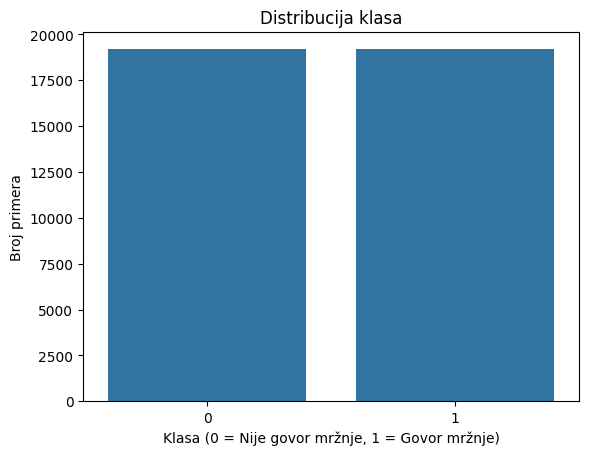

In [39]:
plot_distribution(final, 'label')

In [40]:
num_class_0f = len(final[final['label'] == 0])
num_class_1f = len(final[final['label'] == 1])

print(num_class_0f, num_class_1f)

19189 19190


In [41]:
final = pd.concat([data, final_augmented_df], ignore_index=True)
df_augmented_set1 = final
df_augmented_set1

,tweet,label,clean_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,0,rt mayasolovely woman complain cleaning house ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,rt mleew boy dat cold tyga dwn bad cuffin dat ...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1,rt urkindofbrand dawg rt sbaby life ever fuck ...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1,rt c g anderson viva based look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1,rt shenikaroberts shit hear might true might f...
...,...,...,...
38374,NaN,0,rt cw issi beany l ife
38375,NaN,0,clean dead bir d piece gla ss
38376,NaN,0,rt goddesslaney lajouetreine give sta tement t...
38377,NaN,0,rt yankeeswfan one scout said prado first team...


In [42]:
X_aug1 = df_augmented_set1['clean_tweet']
y_aug1 = df_augmented_set1['label']

run(X_aug1, y_aug1)

Logistička regresija: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      3877
           1       0.92      0.89      0.91      3799

    accuracy                           0.91      7676
   macro avg       0.91      0.91      0.91      7676
weighted avg       0.91      0.91      0.91      7676

Matrica konfuzije:
[[3588  289]
 [ 406 3393]]
SVM: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3877
           1       0.95      0.90      0.92      3799

    accuracy                           0.93      7676
   macro avg       0.93      0.93      0.93      7676
weighted avg       0.93      0.93      0.93      7676

Matrica konfuzije:
[[3678  199]
 [ 361 3438]]
Naive Bayes: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      3877
           1       0.83 

c:\Users\Kaca\Desktop\Master\Prikupljanje i predobrada podataka za mašinsko učenje\Seminarski 2\predobrada\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 90s 179ms/step - accuracy: 0.8369 - loss: 0.3889 - val_accuracy: 0.9009 - val_loss: 0.2715
Epoch 2/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 86s 178ms/step - accuracy: 0.9239 - loss: 0.2140 - val_accuracy: 0.9141 - val_loss: 0.2317
Epoch 3/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 86s 178ms/step - accuracy: 0.9390 - loss: 0.1667 - val_accuracy: 0.9204 - val_loss: 0.2157
Epoch 4/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 89s 185ms/step - accuracy: 0.9524 - loss: 0.1276 - val_accuracy: 0.9222 - val_loss: 0.2201
Epoch 5/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 88s 184ms/step - accuracy: 0.9610 - loss: 0.1034 - val_accuracy: 0.9247 - val_loss: 0.2291
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9218 - loss: 0.2388
LSTM Test Accuracy: 0.9247003793716431
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      3877
           1       0.94      0.91      0.92      3799

   

c:\Users\Kaca\Desktop\Master\Prikupljanje i predobrada podataka za mašinsko učenje\Seminarski 2\predobrada\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


480/480 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.8091 - loss: 0.4231 - val_accuracy: 0.9113 - val_loss: 0.2518
Epoch 2/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step - accuracy: 0.9315 - loss: 0.1969 - val_accuracy: 0.9188 - val_loss: 0.2305
Epoch 3/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step - accuracy: 0.9601 - loss: 0.1192 - val_accuracy: 0.9145 - val_loss: 0.2489
Epoch 4/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.9786 - loss: 0.0673 - val_accuracy: 0.9161 - val_loss: 0.2939
Epoch 5/5
480/480 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.9867 - loss: 0.0408 - val_accuracy: 0.9131 - val_loss: 0.3452
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9104 - loss: 0.3644
CNN Test Accuracy: 0.9131057858467102
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      3877
           1       0.93      0.89      0.91      3799

    accuracy         

#### Augmentirani dataset 2

In [34]:
augmented_data = pd.read_csv('augmented_train.csv')
augmented_df2 = augmented_data[['clean_tweet', 'label']]

In [35]:
num_class_0f = len(augmented_df2[augmented_df2['label'] == 0])
num_class_1f = len(augmented_df2[augmented_df2['label'] == 1])

print(num_class_0f, num_class_1f)

18593 19190


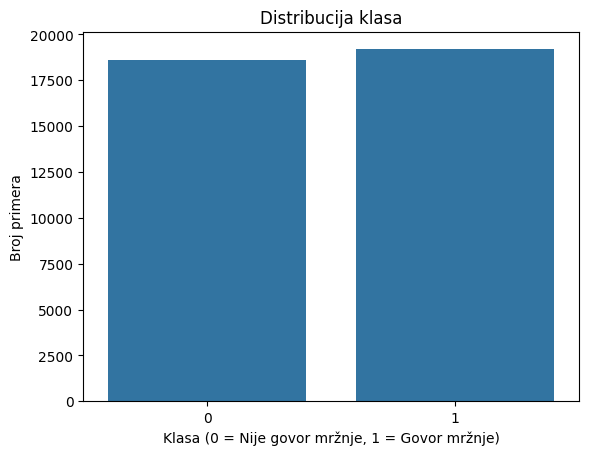

In [36]:
plot_distribution(augmented_df2, 'label')

In [37]:
X_aug2 = augmented_df2['clean_tweet']
y_aug2 = augmented_df2['label']

run(X_aug2, y_aug2)


Logistička regresija: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3738
           1       0.92      0.90      0.91      3819

    accuracy                           0.91      7557
   macro avg       0.91      0.91      0.91      7557
weighted avg       0.91      0.91      0.91      7557

Matrica konfuzije:
[[3429  309]
 [ 392 3427]]
SVM: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      3738
           1       0.95      0.92      0.93      3819

    accuracy                           0.93      7557
   macro avg       0.93      0.93      0.93      7557
weighted avg       0.93      0.93      0.93      7557

Matrica konfuzije:
[[3541  197]
 [ 323 3496]]
Naive Bayes: 
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      3738
           1       0.83 

c:\Users\Kaca\Desktop\Master\Prikupljanje i predobrada podataka za mašinsko učenje\Seminarski 2\predobrada\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 100s 203ms/step - accuracy: 0.8249 - loss: 0.3999 - val_accuracy: 0.9053 - val_loss: 0.2553
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 90s 190ms/step - accuracy: 0.9189 - loss: 0.2219 - val_accuracy: 0.9063 - val_loss: 0.2400
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 157s 222ms/step - accuracy: 0.9352 - loss: 0.1736 - val_accuracy: 0.9153 - val_loss: 0.2222
Epoch 4/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 100s 211ms/step - accuracy: 0.9468 - loss: 0.1387 - val_accuracy: 0.9197 - val_loss: 0.2176
Epoch 5/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.9585 - loss: 0.1094 - val_accuracy: 0.9198 - val_loss: 0.2323
237/237 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.9209 - loss: 0.2262
LSTM Test Accuracy: 0.9198094606399536
237/237 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3738
           1       0.92      0.92      0.92      3819

    accura

c:\Users\Kaca\Desktop\Master\Prikupljanje i predobrada podataka za mašinsko učenje\Seminarski 2\predobrada\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


473/473 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.8076 - loss: 0.4229 - val_accuracy: 0.9063 - val_loss: 0.2527
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.9292 - loss: 0.1939 - val_accuracy: 0.9206 - val_loss: 0.2157
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.9625 - loss: 0.1084 - val_accuracy: 0.9218 - val_loss: 0.2300
Epoch 4/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.9806 - loss: 0.0604 - val_accuracy: 0.9218 - val_loss: 0.2631
Epoch 5/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 48s 101ms/step - accuracy: 0.9868 - loss: 0.0394 - val_accuracy: 0.9242 - val_loss: 0.2891
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9257 - loss: 0.2888
CNN Test Accuracy: 0.9241762757301331
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Izveštaj o klasifikaciji:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3738
           1       0.93      0.91      0.92      3819

    accuracy        